# Project: Investigate the Soccer Database

I have chosen this Database because I am a football enthusiast, and I want to apply the things I have learnt to do some analysis on soccer.

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#limitations">Limitations</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#references">References</a></li>
</ul>

<a id='intro'></a>
## Introduction

This soccer database comes from Kaggle and is well suited for data analysis and machine learning. It contains data for soccer matches, players, and teams from several European countries from 2008 to 2016. This dataset is quite extensive, and we encourage you to read more about it here.

The database is stored in a SQLite database. You can access database files using software like DB Browser.
This dataset will help you get good practice with your SQL joins. Make sure to look at how the different tables relate to each other.
Some column titles should be self-explanatory, and others you’ll have to look up on Kaggle

In [71]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import gaussian_kde
from scipy.interpolate import spline
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

In this section, we will connect to the dB and then import the data into Pandas DataFrames. I will be using the Player and Player_Attributes data to conduct my exploratory analysis. We will first understand what data the DataFrames contain. 

In [72]:
#Connecting to dB
db = sqlite3.connect('database.sqlite')
cur = db.cursor()

for row in db.execute("SELECT name FROM sqlite_master WHERE type='table';"):
    print(row)

(u'sqlite_sequence',)
(u'Player_Attributes',)
(u'Player',)
(u'Match',)
(u'League',)
(u'Country',)
(u'Team',)
(u'Team_Attributes',)


In [73]:
Player = pd.read_sql_query("select * from Player;", db)
Player_Attributes = pd.read_sql_query("select * from Player_Attributes;", db)
#Match = pd.read_sql_query("select * from Match;", db)
#League = pd.read_sql_query("select * from League;", db)
#Country = pd.read_sql_query("select * from Country;", db)
#Team = pd.read_sql_query("select * from Team;", db)
#Team_Attributes = pd.read_sql_query("select * from Team_Attributes;", db)

In [74]:
print('Total rows in Player_Attributes', len(Player_Attributes))
print('Number of unique Players in Player_Attributes', len(Player_Attributes['player_api_id'].unique()))
print('\n')
print('Total rows in Player', len(Player))
print('Number of unique Players in Player', len(Player['player_api_id'].unique()))


('Total rows in Player_Attributes', 183978)
('Number of unique Players in Player_Attributes', 11060)


('Total rows in Player', 11060)
('Number of unique Players in Player', 11060)


In [75]:
#Info of the Player_Attributes DataFrame
Player_Attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
accele

In [76]:
#info of Player DataFrame
Player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
id                    11060 non-null int64
player_api_id         11060 non-null int64
player_name           11060 non-null object
player_fifa_api_id    11060 non-null int64
birthday              11060 non-null object
height                11060 non-null float64
weight                11060 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 604.9+ KB


### Data Cleaning

We will be dropping the columns we won't be using from the DataFrames. And then, we will remove duplicates from the table. And then, check for null values. 

We will be choosing an abstract date from November 2015 as the threshold, and only choosing datapoints ahead of this. This is because we want all the datapoints used for analysis to be from the same timeperiod. 

Then we will be removing the duplicates, by choosing the first occurence. This is done because, it is observed that in the DataFrame the columns are sorted in descending order of their date. And since, we have anyway elimintated all datapoints before November 2015, it is still fine if we pick something other than the latest datapoint.

In [77]:
#Removing all ratings before a chosen threshold date, and then removing duplicates by keeping only latest rating.
threshold = Player_Attributes['date'][1]
print('Choosing this as the threshold date - ', threshold)
Player_Attributes_2 = (Player_Attributes.loc[Player_Attributes['date'] > threshold]).drop_duplicates('player_api_id',keep='first')

('Choosing this as the threshold date - ', u'2015-11-19 00:00:00')


In [78]:
print('Total rows in Player_Attributes', len(Player_Attributes_2))
print('Number of unique Players in Player_Attributes', len(Player_Attributes_2['player_api_id'].unique()))

('Total rows in Player_Attributes', 5858)
('Number of unique Players in Player_Attributes', 5858)


We observe, that the Number of Unique Players have reduced from 11,060 to 5,858. This might be because of some players taking retirement or not having their data updated by FIFA. We will be ignoring those players as we don't have enough information to comment on the same. 

In [79]:
#removing unwanted columns
Player = Player.drop(['id', 'player_fifa_api_id'], axis=1)
Player_Attributes_2 = Player_Attributes_2.drop(['id','player_fifa_api_id','date'], axis=1)

In [80]:
#Merging both dataframes.
Player_data = Player.merge(Player_Attributes_2, left_on='player_api_id', right_on='player_api_id', how='inner')

Here we removed the unwanted columns. And, then we merged the two DataFrames based on the player_api_id. A inner join is used, so that values present in both the DataFrames only occur in the merged one.

This will be the data we will be using for the analysis.

In [81]:
print('Total rows in Player_data', len(Player_data))
print('Number of unique Players in Player_data', len(Player_data['player_api_id'].unique()))

('Total rows in Player_data', 5858)
('Number of unique Players in Player_data', 5858)


In [82]:
#Checking if there are any duplicates.
sum(Player_data.duplicated())

0

In [83]:
#Checking for null values
Player_data.isnull().sum()

player_api_id          0
player_name            0
birthday               0
height                 0
weight                 0
overall_rating         0
potential              0
preferred_foot         0
attacking_work_rate    0
defensive_work_rate    0
crossing               0
finishing              0
heading_accuracy       0
short_passing          0
volleys                0
dribbling              0
curve                  0
free_kick_accuracy     0
long_passing           0
ball_control           0
acceleration           0
sprint_speed           0
agility                0
reactions              0
balance                0
shot_power             0
jumping                0
stamina                0
strength               0
long_shots             0
aggression             0
interceptions          0
positioning            0
vision                 0
penalties              0
marking                0
standing_tackle        0
sliding_tackle         0
gk_diving              0
gk_handling            0


We observe that there are no duplicates present, and no null values either.

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.


Here is the dataset after all the cleaning. 

In [84]:
Player_data

,player_api_id,player_name,birthday,height,weight,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,67.0,71.0,right,medium,medium,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,155782,Aaron Cresswell,1989-12-15 00:00:00,170.18,146,74.0,76.0,left,high,medium,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
2,162549,Aaron Doran,1991-05-13 00:00:00,170.18,163,65.0,67.0,right,medium,medium,...,68.0,61.0,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0
3,30572,Aaron Galindo,1982-05-08 00:00:00,182.88,198,69.0,69.0,right,medium,medium,...,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0
4,23780,Aaron Hughes,1979-11-08 00:00:00,182.88,154,70.0,70.0,right,medium,medium,...,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0
5,27316,Aaron Hunt,1986-09-04 00:00:00,182.88,161,77.0,77.0,left,medium,medium,...,76.0,81.0,28.0,34.0,35.0,15.0,12.0,7.0,16.0,15.0
6,564793,Aaron Kuhl,1996-01-30 00:00:00,172.72,146,61.0,74.0,right,medium,high,...,61.0,42.0,52.0,58.0,57.0,8.0,13.0,14.0,14.0,15.0
7,528212,Aaron Lennox,1993-02-19 00:00:00,190.50,181,48.0,56.0,right,medium,medium,...,15.0,41.0,15.0,15.0,12.0,53.0,41.0,39.0,51.0,53.0
8,101042,Aaron Meijers,1987-10-28 00:00:00,175.26,170,69.0,69.0,left,medium,medium,...,71.0,56.0,67.0,68.0,65.0,7.0,15.0,7.0,10.0,15.0
9,231592,Aaron Mooy,1990-09-15 00:00:00,175.26,150,75.0,78.0,right,medium,medium,...,81.0,73.0,56.0,65.0,62.0,11.0,8.0,12.0,11.0,12.0


### Research Question 1 - How does FIFA assign overall_rating? Is it absolute? Or is it relative? Can we get some insights from the data?

We are plotting a histogram of the overall_rating, to observe how the distribution is made by FIFA. We observe that, the histogram gives a normal distribution. Based on which, it is fair to say FIFA uses some kind of normalization  before giving the rating to players.

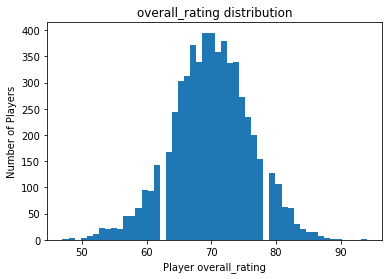

In [85]:
plt.hist(Player_data['overall_rating'], bins=50)
plt.ylabel('Number of Players')
plt.title('overall_rating distribution')
plt.xlabel('Player overall_rating')
plt.show()

### Research Question 2 - Who are the top 20 players?
Here, we are sorting based on overall_rating. And then using their birthdate to resolve clashes, if any. The younger players are given a higher ranking.

Key take-aways from this, as a football enthusiast. Ronaldo is missing. Must have gotten cleaned up in the data cleaning phase. This might be due to the fact, that his data might not have been updated after November 2015, to the time the data dump was taken. 

In [86]:
Player_data.sort_values(['overall_rating', 'birthday'], ascending=[0, 0])[:20]

,player_api_id,player_name,birthday,height,weight,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
3240,30981,Lionel Messi,1987-06-24 00:00:00,170.18,159,94.0,94.0,left,medium,low,...,90.0,74.0,13.0,23.0,21.0,6.0,11.0,15.0,14.0,8.0
4175,19533,Neymar,1992-02-05 00:00:00,175.26,150,90.0,94.0,right,high,medium,...,79.0,81.0,21.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3456,27299,Manuel Neuer,1986-03-27 00:00:00,193.04,203,90.0,90.0,right,medium,medium,...,70.0,37.0,10.0,10.0,11.0,85.0,87.0,91.0,90.0,87.0
531,30834,Arjen Robben,1984-01-23 00:00:00,180.34,176,89.0,89.0,left,high,low,...,84.0,80.0,29.0,26.0,26.0,10.0,8.0,11.0,5.0,15.0
1496,107417,Eden Hazard,1991-01-07 00:00:00,172.72,163,88.0,90.0,right,high,medium,...,86.0,86.0,25.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0
3882,36378,Mesut Oezil,1988-10-15 00:00:00,182.88,168,88.0,89.0,left,medium,low,...,93.0,76.0,22.0,16.0,19.0,6.0,14.0,10.0,6.0,14.0
4778,93447,Robert Lewandowski,1988-08-21 00:00:00,185.42,174,88.0,89.0,right,medium,medium,...,78.0,77.0,25.0,42.0,19.0,15.0,6.0,12.0,8.0,10.0
5117,37412,Sergio Aguero,1988-06-02 00:00:00,172.72,163,88.0,88.0,right,high,medium,...,83.0,83.0,13.0,20.0,12.0,13.0,15.0,6.0,11.0,14.0
2389,164684,James Rodriguez,1991-07-12 00:00:00,180.34,165,87.0,93.0,left,medium,medium,...,87.0,81.0,25.0,47.0,30.0,15.0,15.0,15.0,5.0,14.0
1247,182917,David De Gea,1990-11-07 00:00:00,193.04,181,87.0,90.0,right,medium,medium,...,68.0,40.0,13.0,21.0,13.0,88.0,81.0,86.0,85.0,89.0


Calculating age for all players for further analysis.

In [87]:
def calculate_age(born):
    today = datetime.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

age_array =[]

for birth_date in Player_data['birthday']:
    birth_date = datetime.strptime(birth_date,'%Y-%m-%d %H:%M:%S')
    age_array.append(calculate_age(birth_date))
    
age_column = pd.Series(age_array)
Player_data['age'] = age_column.values

### Research Question 3 - How does age affect the players acceleration and stamina?

We calculate average of acceleration and stamina, grouped by age. And then try to analyze by plotting a graph.
We observe that, acceleration peaks between 20-27 years, and then goes down a steady decline. Indicating players are fast during their prime, and slow down as they age.
But an interesting trend observed with the stamina, is that stamina peaks between 28-33. This probably can be attributed to better understanding of the game. Or, because of the reduced acceleration which helps conserve energy.

In [88]:

def plot_multiple(data, features, smooth, smoothness):
    legend =[]
    for feature in features:
        x = data.index
        y = data[feature]
        if(smooth):
            xnew = np.linspace(x.min(),x.max(),smoothness)
            power_smooth = spline(x,y,xnew)
            x = xnew
            y = power_smooth
        plt.plot(x, y)
        legend.append(feature)
    plt.legend(legend, loc='bottom left')
    plt.show()
    

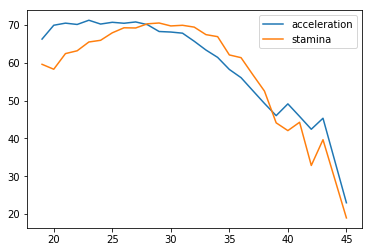

In [89]:
features = ['acceleration','stamina']
average_over_age = Player_data.groupby(['age'])[features].mean()
plot_multiple(average_over_age, features, False, 0)

### Research Question 4 - How do height and weight affect a Goal Keepers skills?

We will try to determine, if the Goal Keeper skills are affected by the player's height and weight. We isolate the Goal Keepers from the list of players using a simple filter of gk_diving > 50. This is based on the assumption that any decent goalkeeper will have a diving of at least 60.

We analyzed four attributes - 
1. Diving - Diving is GK’s ability to make a save whilst diving through the air.
2. Handling - Handling is an exclusive goalkeeper attribute used to measures how cleanly he catches the ball and does he hold on to it.
3. Positioning - GK’s ability to position himself correctly when saving shots.
4. Reflexes - Reflexes stat is the agility of the goalkeeper when making a save.

When analyzing based on height, I did not find anything conclusive based on the data.

But when analyzing based on weight, we observe that both Reflexes and Diving attributes go downhill as the weight increases. Both these attributes are inversely proportionate to weight of the player. This corelation can be due to the fact, that an increased weight invariably decreases body movement. Hence, directly affecting reflexes. Even the diving ability of the GoalKeeper will decrease as weight increases, as the player won't have the same flexibility as compared to a lighter goalkeeper.

In [90]:
GK_data = (Player_data.loc[Player_data['gk_diving'] > 60])

In [91]:
GK_data.describe()

,player_api_id,height,weight,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,age
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,...,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,142725.872941,189.215059,184.597647,70.576471,72.663529,14.108235,13.423529,14.268235,28.272941,14.178824,...,21.783529,13.505882,13.745882,13.908235,72.734118,68.110588,66.160000,69.840000,74.141176,30.475294
std,142197.001190,4.519237,12.233402,6.146360,6.371162,3.519160,3.070617,4.021001,7.473592,3.490692,...,8.010619,2.925262,2.870045,3.047355,6.279826,7.073036,7.724184,6.936559,6.611084,4.889339
min,2796.000000,177.800000,152.000000,50.000000,55.000000,7.000000,5.000000,8.000000,11.000000,6.000000,...,9.000000,3.000000,6.000000,5.000000,61.000000,46.000000,41.000000,47.000000,43.000000,19.000000
25%,36374.000000,185.420000,176.000000,66.000000,68.000000,12.000000,11.000000,12.000000,23.000000,12.000000,...,16.000000,12.000000,12.000000,12.000000,68.000000,63.000000,61.000000,65.000000,70.000000,27.000000
50%,95336.000000,187.960000,183.000000,70.000000,72.000000,13.000000,13.000000,13.000000,29.000000,13.000000,...,21.000000,13.000000,13.000000,13.000000,72.000000,68.000000,66.000000,70.000000,74.000000,30.000000
75%,202632.000000,193.040000,192.000000,74.000000,77.000000,16.000000,15.000000,16.000000,33.000000,16.000000,...,24.000000,15.000000,15.000000,16.000000,77.000000,73.000000,71.000000,75.000000,79.000000,34.000000
max,698273.000000,203.200000,218.000000,90.000000,90.000000,33.000000,29.000000,53.000000,52.000000,26.000000,...,68.000000,23.000000,23.000000,24.000000,88.000000,87.000000,91.000000,90.000000,90.000000,45.000000


In [92]:
gk_features = ['gk_diving','gk_handling','gk_positioning','gk_reflexes']

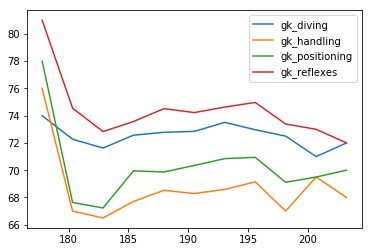

In [93]:
average_over_height = GK_data.groupby(['height'])[gk_features].mean()
plot_multiple(average_over_height, gk_features, False, 0)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  if __name__ == '__main__':


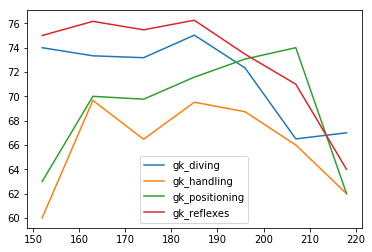

In [94]:
average_over_weight = GK_data.groupby(['weight'])[gk_features].mean()
plot_multiple(average_over_weight, gk_features, True, 7)

<a id='limitations'></a>
## Limitations

Well, the dataset is not exhaustive. Hence, any inferences we have made are not absolute. 
Few players (For example - Ronaldo) got truncated in the cleaning process. Hence, the top 20 players described, may not be completely correct.
A lot of assumptions are made throughout the analysis, based on my ease and preference of working. Which need not be necessarily right.

<a id='conclusions'></a>
## Conclusions

From our analysis, we have determined the following things.
1. FIFA probably uses some kind of normalization for assigning overall_rating. 
2. We figured out who the top 20 players are, from our cleaned dataset.
3. We observe that, acceleration peaks between 20-27 years, and then goes down a steady decline
4. We also figured out, that the stamina peaks between 28-33 years. And then declines as the player ages.
5. For GoalKeepers, we observed that both Reflexes and Diving attributes decrease as the weight increases.

<a id='References'></a>
## References


1. https://www.fifauteam.com/fifa-18-attributes-guide/
2. https://stackoverflow.com
3. https://pandas.pydata.org/pandas-docs/stable/
4. https://matplotlib.org/contents.html
5. https://docs.scipy.org/

In [95]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'investigate-a-dataset-soccer.ipynb'])

0